# Evaluating Predictive Models: Logistic Regression versus Neural Networks in Traffic Accident Data Analysis

### Abstract

------

## Introduction

## Literature review

**Deep Belief Networks** (DBN) ...


- Requirements: Packages used to run the analysis and global variables

In [16]:
#  Packages for data manipulation and processing
import numpy as np                      # list and matrix calculation
import pandas as pd                     # csv file processing

# Supervied leraning analysis tools
import torch                                    
import torch.nn as nn                           # neural network moduls
import torch.optim as optim                     # optimizer in NN
from torch.nn import Dropout, BatchNorm1d       # Net structures

from torch.utils.data import TensorDataset, DataLoader # data load related libs
from torch.utils.data import Dataset            # training dataset class
from torch.utils.data import random_split       # randomly split a dataset into multiple subsets


from sklearn.preprocessing import LabelEncoder  # encode target value to label
from sklearn.model_selection import train_test_split # single split dataset
from sklearn.model_selection import KFold       # cross-validation
from sklearn.decomposition import PCA           # PCA for Dimensionality Reduction
# Import logistic regression method
from sklearn.linear_model import LogisticRegression 
# Model evaluation tools
from sklearn.metrics import accuracy_score
# Hyperparameter Tuning lib
from sklearn.model_selection import GridSearchCV

# Data analysis tools
from statsmodels.stats.outliers_influence import variance_inflation_factor  # Calculate vif

# Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns                   # built-in themes to draw attractive and informative statistical graphics.

In [17]:
# raw data relative path
collisionDataPath = "./data/dft-road-casualty-statistics-collision-last-5-years.csv"
casualtyDataPath = "./data/dft-road-casualty-statistics-casualty-last-5-years.csv"
# dtype: str location indicator of raw data
dtype_specification = {0: str, 2: str, 18: str}

### Data gathering
[Ref](https://machinelearningmastery.com/pytorch-tutorial-develop-deep-learning-models/)

In [18]:

# Dataset class def
class TrainDataset(Dataset):

    def __init__(self, path, loc_remove:list[str], loc_test=None, dtype:dict=None):
        """
        Training dataset initialization method used to convert the data frame from csv file
        into list array style that can be used for batch seperation.
        
        Parameters
        ------
        path : str, pd.DataFrame
            The relative file path of dataset
            Can also input data frame directly
        loc_remove : list[str]
            The columns will be removed
        loc_test : list[str], optinal
            The index of testing columns
        dtype : dict, optional
            The specific data type of column(s)
        """
        # load the csv file as a dataframe
        if(isinstance(path, pd.DataFrame)):
            df = path
        else:
            df = pd.read_csv(path, dtype=dtype)
        # remove useless columns
        df = df.drop(columns=loc_remove)
        # print first row to preview df
        df.head(1)
        # stroe the df
        self.raw = df
        # The training and testing data
        self.X = None
        self.y = None
        self.test = loc_test

    def __len__(self):
        """
        Check the size of dataset.

        Return
        ------
        len(self.X) : int
            The size of X
        """
        print(f"Training dataset length: {len(self.X)}, test dataset length: {len(self.y)}")
        return len(self.X)

    # get a row at an index
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]

    def get_train_test_split(self):
        # store the inputs and outputs
        if self.test is None:
            self.X = self.raw.values[:, :-1]
            self.y = self.raw.values[:, -1]
        else:
            self.X = self.raw.drop(columns=self.test).to_numpy()
            self.y = self.raw[self.test].values.ravel()
            # NotImplementedError()
        # label encode target
        self.y = LabelEncoder().fit_transform(self.y)
        # ensure output data is floats
        self.y = self.y.astype('float32')
        # reshapes output array to have len(self.y) rows and 1 column
        self.y = self.y.reshape((len(self.y), 1))

    def reset_raw_data(self, new_df, loc_test=None):
        self.raw = new_df
        if loc_test is not None:
            self.test = loc_test
        # Assign X and y
        self.get_train_test_split()

    def shape(self):
        return self.raw.shape

    def describe(self, cols: list[str]=None):
        """
        generates descriptive statistics that summarize the df.

        Parameter
        ------
        cols: list[str]
            specific clumns that will be described
        """
        if cols is not None:
            print(self.raw[cols].describe(include='all'))
        else:
            print(self.raw.describe(include='all'))

    def clean_na(self):
        """
        data processing step. 
        Remove rows with any null values and replace '-1' with NaN,
        then remove any rows with NaN values.
        """
        self.raw = self.raw.dropna()
        self.raw = self.raw.replace(-1, pd.NA).dropna()
        self.raw = self.raw.replace('-1', pd.NA).dropna()

    def get_splits(self, n_test=0.33):
        """
        split the dataset and get indexes for train and test rows.

        Parameter
        ------
        n_test : float
            The split ratio of testing dataset [0, 1]
        """
        # determine sizes
        test_size = round(n_test * len(self.X))
        train_size = len(self.X) - test_size
        # calculate the split
        return random_split(self, [train_size, test_size])

### Data pre-processing

Checking the note in the data readme file, -1 means there is a data fail to be recored or out of the range.

In [19]:
casualtyDataset = TrainDataset(casualtyDataPath, loc_remove=['accident_index', 'accident_year', 
       'vehicle_reference', 'casualty_reference',
       'pedestrian_road_maintenance_worker', 'lsoa_of_casualty'],
             dtype=dtype_specification)
collisionDataset = TrainDataset(collisionDataPath, loc_remove=['accident_index', 'accident_year',
       'location_easting_osgr', 'location_northing_osgr', 'longitude',
       'latitude', 'police_force', 'date', 'time', 'local_authority_district',
       'local_authority_ons_district', 'local_authority_highway', 'first_road_number', 
       'second_road_number', 'did_police_officer_attend_scene_of_accident',
       'lsoa_of_accident_location'],
       dtype=dtype_specification)

casualtyDataset.clean_na()
collisionDataset.clean_na()

In [20]:
"""
The target columns are: 'casualty_severity', 'road_type'
However, the y column that used for prediction has to be one dismension.
Therefor, a look up table that saves the combination of these two columns has
to be created.
"""
# Define the pairs [1, 2, 3] [1, 2, 3, 6, 7, 9, 12]
pairs = [(1, 1), (0, 3), (0, 4), (0, 7), (1, 1), (1, 3), (1, 7), (2, 7)]

def get_look_up_table(list1, list2):
    lookup_table = {}
    counter = 0
    # Map each unique pair to a unique integer, incrementing sequentially.
    for item1 in list1:
        for item2 in list2:
            lookup_table[(item1, item2)] = counter
            counter += 1
    return lookup_table

lookup_table = get_look_up_table([1, 2, 3], [1, 2, 3, 6, 7, 9, 12])
# Print the lookup table
for pair, value in lookup_table.items():
    print(f"Pair: {pair}, Value: {value}")

# Apply the lookup table to each row
def lookup_value(row, class1='accident_severity', class2='road_type'):
    try:
        return lookup_table[(row[class1], row[class2])]
    except KeyError as e:
        print(f"KeyError for row: {row.to_dict()}")
        return None

Pair: (1, 1), Value: 0
Pair: (1, 2), Value: 1
Pair: (1, 3), Value: 2
Pair: (1, 6), Value: 3
Pair: (1, 7), Value: 4
Pair: (1, 9), Value: 5
Pair: (1, 12), Value: 6
Pair: (2, 1), Value: 7
Pair: (2, 2), Value: 8
Pair: (2, 3), Value: 9
Pair: (2, 6), Value: 10
Pair: (2, 7), Value: 11
Pair: (2, 9), Value: 12
Pair: (2, 12), Value: 13
Pair: (3, 1), Value: 14
Pair: (3, 2), Value: 15
Pair: (3, 3), Value: 16
Pair: (3, 6), Value: 17
Pair: (3, 7), Value: 18
Pair: (3, 9), Value: 19
Pair: (3, 12), Value: 20


In [21]:
# Merge the casulty and collision data set together by right
collision_casualty_merged = pd.merge(casualtyDataset.raw, collisionDataset.raw, how='right', on='accident_reference')
# Check how many null values existed in merged result
print(collision_casualty_merged.isnull().sum()) 
# Appl look up table to combine two classes together
collision_casualty_merged['labels'] = collision_casualty_merged.apply(lookup_value, axis=1)
# Get final dataset used for trainning
dataSet = TrainDataset(collision_casualty_merged, loc_remove=['accident_reference', 'casualty_severity', 'casualty_type',
                                                            'accident_severity', 'road_type'],
                       loc_test=['labels'])

accident_reference                             0
casualty_class                             23796
sex_of_casualty                            23796
age_of_casualty                            23796
age_band_of_casualty                       23796
casualty_severity                          23796
pedestrian_location                        23796
pedestrian_movement                        23796
car_passenger                              23796
bus_or_coach_passenger                     23796
casualty_type                              23796
casualty_home_area_type                    23796
casualty_imd_decile                        23796
accident_severity                              0
number_of_vehicles                             0
number_of_casualties                           0
day_of_week                                    0
first_road_class                               0
road_type                                      0
speed_limit                                    0
junction_detail     

In [22]:
# Remove Null and invalid value
dataSet.clean_na()
dataSet.get_train_test_split()

print(dataSet.shape())

(326753, 28)


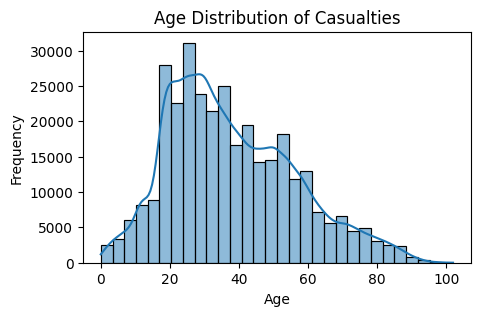

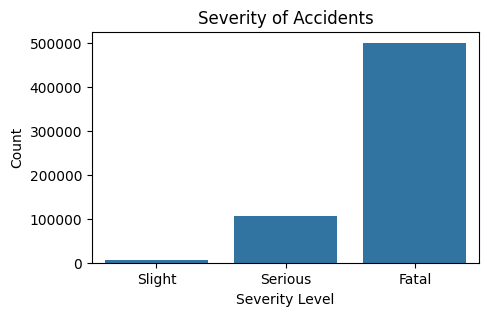

Text(0, 0.5, 'Casualty Type')

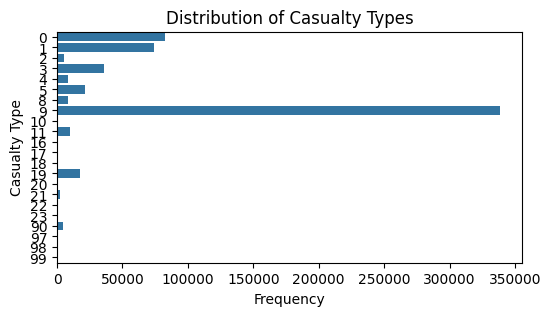

In [23]:
# Ensure proper rendering of plots
%matplotlib inline
# # 1. Trend of Accidents Over Years
# plt.figure(figsize=(10, 6))
# sns.countplot(x='accident_year', data=df)
# plt.title('Trend of Accidents Over Years')
# plt.ylabel('Number of Accidents')
# plt.xlabel('Year')
# plt.xticks(rotation=45)
# plt.show()

# 2. Age Distribution of Casualties
plt.figure(figsize=(5, 3))
sns.histplot(dataSet.raw['age_of_casualty'], bins=30, kde=True)
plt.title('Age Distribution of Casualties')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# 3. Severity of Accidents
plt.figure(figsize=(5, 3))
sns.countplot(x='casualty_severity', data=casualtyDataset.raw)
plt.title('Severity of Accidents')
plt.xlabel('Severity Level')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2], labels=['Slight', 'Serious', 'Fatal'])
plt.show()

# 4. Casualty Type Distribution
plt.figure(figsize=(6, 3))
# Count the frequency of each casualty type
casualty_type_counts = casualtyDataset.raw['casualty_type'].value_counts().sort_values(ascending=False)
# Plot as a bar chart
sns.barplot(x=casualty_type_counts.values, y=casualty_type_counts.index, orient='h')
plt.title('Distribution of Casualty Types')
plt.xlabel('Frequency')
plt.ylabel('Casualty Type')

In [24]:
def calculate_vif(df):
    # Calculating VIF for each independent variable
    vif_data = pd.DataFrame()
    vif_data['feature'] = df.columns
    vif_data['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

    print(vif_data)
    return vif_data

def remove_multicollinear_columns(df, vif_threshold=10.0):
    """
    Removes columns from the dataframe df that have a variance inflation factor (VIF) greater than the threshold.
    """
    # Calculate VIF for each feature
    vif_data = calculate_vif(df)
    
    # Find features with VIF exceeding the threshold
    features_to_drop = vif_data[vif_data['VIF'] > vif_threshold]['feature']
    
    # Drop the features from the original dataframe
    df_reduced = df.drop(columns=features_to_drop)
    
    return df_reduced, features_to_drop

In [25]:
df_raw = dataSet.raw.drop('labels', axis=1)
# convert the data into numeric fromat to ensure the correct process
df_raw = df_raw.apply(pd.to_numeric, errors='coerce')
# get reduced df after appplying VIF remove
df_raw_fited, _ = remove_multicollinear_columns(df_raw, 10)
# add the dropped Y label column back again
df_raw_fited['labels'] = dataSet.raw['labels']
# re-assign the df back to object
dataSet.reset_raw_data(df_raw_fited, loc_test=['labels'])

                                    feature         VIF
0                            casualty_class   18.792047
1                           sex_of_casualty    9.626460
2                           age_of_casualty  104.898271
3                      age_band_of_casualty  202.885403
4                       pedestrian_location    4.956287
5                       pedestrian_movement    3.164539
6                             car_passenger    1.969606
7                    bus_or_coach_passenger    1.133619
8                   casualty_home_area_type    6.930493
9                       casualty_imd_decile    4.443457
10                       number_of_vehicles   14.193879
11                     number_of_casualties    4.147686
12                              day_of_week    5.495636
13                         first_road_class   12.438516
14                              speed_limit   16.922291
15                          junction_detail    1.724562
16                         junction_control   14

There are too many x-properties that going to be used, combining some of them together may benifit the model.

In [26]:
# merge similar data columns into one singe column
dataSet.raw['casualty_state'] = dataSet.raw['casualty_home_area_type'] * dataSet.raw['casualty_imd_decile']
dataSet.raw['pedestarin_crossing_state'] = dataSet.raw['pedestrian_crossing_human_control'] + dataSet.raw['pedestrian_crossing_physical_facilities']

# remove above used columns
dropColumns = ['casualty_home_area_type', 'casualty_imd_decile', 
               'pedestrian_crossing_human_control', 'pedestrian_crossing_physical_facilities']

# drop
dataSet.raw = dataSet.raw.drop(dropColumns, axis=1)
# re-assign the df back to object
dataSet.reset_raw_data(dataSet.raw, loc_test=['labels'])

display(dataSet.raw.head(6))

,sex_of_casualty,pedestrian_location,pedestrian_movement,car_passenger,bus_or_coach_passenger,number_of_casualties,day_of_week,junction_detail,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,labels,casualty_state,pedestarin_crossing_state
0,1,5,1,0,0,1,2,2,4,1,1,0,0,17,3,0
1,1,0,0,0,0,1,2,6,4,1,1,0,0,17,3,5
2,1,0,0,0,0,1,2,7,4,2,2,0,0,9,7,5
3,1,0,0,0,0,1,2,2,4,1,1,0,0,10,3,0
4,2,0,0,0,0,1,2,5,7,1,1,0,0,15,3,0
5,1,0,0,0,0,1,2,3,4,1,1,0,0,17,6,8


In [27]:
# Data split into training and testing sets with a 7:3 ratio
train_X, test_X, train_y, test_y = train_test_split(dataSet.X, dataSet.y, test_size=0.3, random_state=2024)

print(f"Training data shape: {dataSet.X.shape}")
print(f"Testing data shape: {dataSet.y.shape}")

Training data shape: (326753, 15)
Testing data shape: (326753, 1)


In [28]:
# Ref: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
# min(n_samples, n_features)=15 (0, 15]
pca = PCA(n_components=10, svd_solver='auto')   # Reducedprincipal components
train_X = pca.fit_transform(train_X)            # Fit the model with X and apply the dimensionality reduction on X
test_X = pca.transform(test_X)                  # Apply dimensionality reduction to X

Reasons why choose logistic regression

In [30]:
# Instantiate the model
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=100)

# Train the model
logreg.fit(train_X, train_y.ravel())

# Predict on the test set
y_pred = logreg.predict(test_X)

# Evaluate the model
print("Accuracy:", accuracy_score(test_y, y_pred))


Accuracy: 0.6042070471099504


e:\python_37\python_prj\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [31]:
# Define the neural network models
class Model_1(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Model_1, self).__init__()
        self.layer1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_classes)
        # No softmax here, CrossEntropyLoss will handle that

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer_out(x)  # Outputs are logits
        return x
    
class Model_2(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Model_2, self).__init__()
        self.layer1 = nn.Linear(input_size, 100)
        self.layer2 = nn.Linear(100, 100)
        self.layer_out = nn.Linear(100, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer_out(x)  # Outputs are logits
        return x
    
class Model_3(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Model_3, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, num_classes)
        )
    
    def forward(self, x):
        return self.network(x)
    
class Model_4(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Model_4, self).__init__()
        self.layer_1 = nn.Linear(input_size, hidden_size)
        self.layer_2 = nn.Linear(hidden_size, hidden_size)
        self.layer_out = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()
        # add dropout to the neural network to help prevent overfitting
        self.dropout = Dropout(p=0.5)
        # add batch normalization to improve training stability.
        self.batchnorm1 = BatchNorm1d(hidden_size)
        self.batchnorm2 = BatchNorm1d(hidden_size)
        
    def forward(self, x):
        x = self.relu(self.layer_1(x))
        x = self.batchnorm1(x)
        x = self.dropout(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        return x

In [39]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(train_X.astype('float32'), dtype=torch.float32)
X_test_tensor = torch.tensor(test_X.astype('float32'), dtype=torch.float32)
y_train_tensor = torch.squeeze(torch.tensor(train_y, dtype=torch.long))
y_test_tensor = torch.squeeze(torch.tensor(test_y, dtype=torch.long))

print("Unique labels in train_y:", torch.unique(y_train_tensor))

# Define the dataset and dataloader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

input_size = train_X.shape[1]
print(input_size)
# The number of classes
num_classes = 18        # After observing the unique labes, there are 0-17 total 18 classes
hidden_size = 128
epochs = 5

# model = Model_3(input_size=input_size, num_classes=num_classes)
model = Model_4(input_size=input_size, hidden_size=hidden_size, num_classes=num_classes)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

isTrain = True

if not isTrain:
    print()
else:
    print("Start training...")
    # Train the model
    for epoch in range(epochs):
        batch_counter = 0

        for inputs, targets in train_loader:
            if inputs.size(0) > 1:  # Check if batch size is greater than 1
                inputs, targets = inputs.float(), targets.long()  # Ensure correct types
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            else:
                # print("Encountered batch size of 1, skipping...")
                continue
                
        # print current training state    
        print(f"epoch: {epoch}, Loss: {loss.item()}")    

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)
    print(f'Accuracy: {accuracy * 100:.2f}%')

    # Make predictions (on unseen data)
    with torch.no_grad():
        sample_data = X_test_tensor[:5]
        sample_preds = model(sample_data)
        _, predicted_classes = torch.max(sample_preds, 1)
    print(f'Predicted classes: {predicted_classes.numpy()}')

Unique labels in train_y: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])
10
Start training...
epoch: 0, Loss: 0.8742703199386597
epoch: 1, Loss: 1.2506909370422363
epoch: 2, Loss: 1.0636415481567383
epoch: 3, Loss: 0.9951316118240356
epoch: 4, Loss: 1.0309399366378784
Accuracy: 60.85%
Predicted classes: [15 12 15 15 12]


5 epoch training:

Model 1 merged columns result: 61.50%

Model 2 merged columns result: 61.47%

Model 3 merged columns result: 60.97%

Model 4 merged columns result: 60.85%

In [40]:
torch.save(model, 'model_4.pth')

In [37]:
model_loaded = torch.load('model_3.pth')

# Set the model to evaluation mode
model_loaded.eval()
with torch.no_grad():
    outputs = model_loaded(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 61.46%


For cross-validation, KFold or StratifiedKFold from sklearn.model_selection, which splits the dataset into k consecutive folds, will be used. Each fold is then used once as a validation while the $k-1$ remaining folds form the training set. This process is repeated $k$ times (folds), with each of the $k$ folds used exactly once as the validation data.

In [14]:
# Setup cross-validation with 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=2024)

# Example: Print the indices of the data for each fold
for train_index, test_index in kf.split(dataset.X):
    print("Train:", train_index, "Test:", test_index)
    X_train, X_test = dataset.X[train_index], dataset.X[test_index]
    y_train, y_test = dataset.y[train_index], dataset.y[test_index]

Train: [     0      1      2 ... 538456 538459 538460] Test: [     4      6      7 ... 538448 538457 538458]
Train: [     1      3      4 ... 538457 538458 538460] Test: [     0      2      5 ... 538453 538455 538459]
Train: [     0      2      3 ... 538458 538459 538460] Test: [     1      8     13 ... 538441 538447 538454]
Train: [     0      1      2 ... 538457 538458 538459] Test: [     3     14     16 ... 538450 538451 538460]
Train: [     0      1      2 ... 538458 538459 538460] Test: [     9     10     19 ... 538438 538439 538456]
